# **Trabajo Práctico 2**





# **Aprendizaje Automático 2**

**Facultad de Ciencias Exactas, Ingeniería y Agrimensura - TUIA**

**Alumnos:**


*   Ferrero Santiago
*   Loza Santiago



----------------------------------------------------------------------------------------------------------------------------------------------------------------



Enunciado: https://docs.google.com/document/d/e/2PACX-1vRWZYM_U5JlyejIB1bMkTOl8V06tsh0OAYM21LVQCMg_AkjBcn2ATfF6jXgKA2qiUlgv7rqcu50QHQY/pub

## Preparación del entorno.

Importamos las librerias necesarias

In [6]:
#!pip install -U tensorflow

In [7]:
#!pip install -U tensorflow==2.15

In [8]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds
from IPython import display
from sys import breakpointhook
from IPython.display import Audio, display
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

Establecer GPU por defecto en caso de estar disponible.

In [9]:
tf.__version__

'2.16.1'

In [10]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

Physical devices cannot be modified after being initialized


In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Sep 16 23:08:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             34W /  250W |   15771MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 33.7 gigabytes of available RAM

You are using a high-RAM runtime!


# Problema 1 - Audio MNIST

Descripción:


En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

Dataset:
https://www.tensorflow.org/datasets/catalog/spoken_digit


El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.

Objetivo:


Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

## Descargar dataset:


In [13]:
# Cargamos el conjunto de datos y lo dividimos en entrenamiento (80%) y prueba (20%)
ds_train_split, ds_test_split, = tfds.load(
    'spoken_digit',
    batch_size=64,
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=False

)

# Contamos el numero de batches
num_train_examples = sum(1 for _ in ds_train_split)
num_test_examples = sum(1 for _ in ds_test_split)

# Mostramos
print('Número de batches de entrenamiento:', num_train_examples)
print('Número de batches de prueba:', num_test_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.LTJOAP_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.
Número de batches de entrenamiento: 32
Número de batches de prueba: 8


In [14]:
#Funcion que obtiene las clases unicas de un dataset
def get_classes(dataset):
    classes = set()
    for _, label in tfds.as_numpy(dataset):
      for i in label:
        classes.add(i)
    return classes

# Obtenemos las clases de train y test
train_classes = get_classes(ds_train_split)
test_classes = get_classes(ds_test_split)

labels_name = [i for i in train_classes]

# Mostramos
print('Clases en el conjunto de entrenamiento:', train_classes)
print('Clases en el conjunto de prueba:', test_classes)

Clases en el conjunto de entrenamiento: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Clases en el conjunto de prueba: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [15]:
for example_audio, example_labels in ds_train_split.take(4):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 6457)
(64,)
(64, 5201)
(64,)
(64, 6074)
(64,)
(64, 6845)
(64,)


In [16]:
for example_audio, example_labels in ds_train_split.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 6457)
(64,)


In [17]:
ds_train_split.take(1).take(2)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
for waveform, label in tfds.as_numpy(ds_train_split.take(1)):
  print(waveform, label)

[[   0    0 -256 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [ -10   -6  -25 ...  -26   -8  -14]
 ...
 [ 135  143   77 ...    0    0    0]
 [   0   -2    4 ...    0    0    0]
 [  16   14   33 ...    0    0    0]] [2 1 9 9 7 5 3 6 1 8 1 5 5 4 8 6 4 6 4 2 4 3 3 7 4 0 6 4 7 8 1 9 6 7 7 4 6
 8 3 2 4 5 8 2 9 9 2 9 9 1 5 2 6 7 5 8 1 0 9 1 8 9 8 0]


Visualizamos

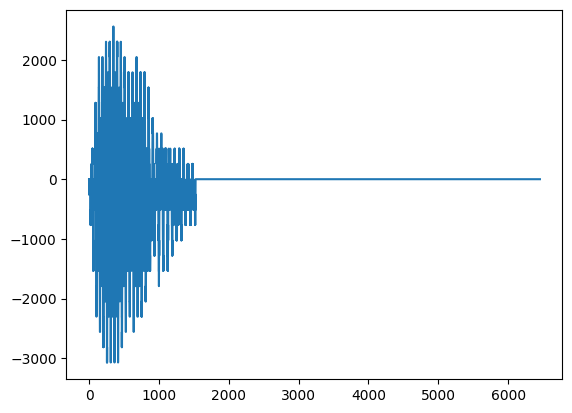

In [19]:
plt.plot(waveform[0])

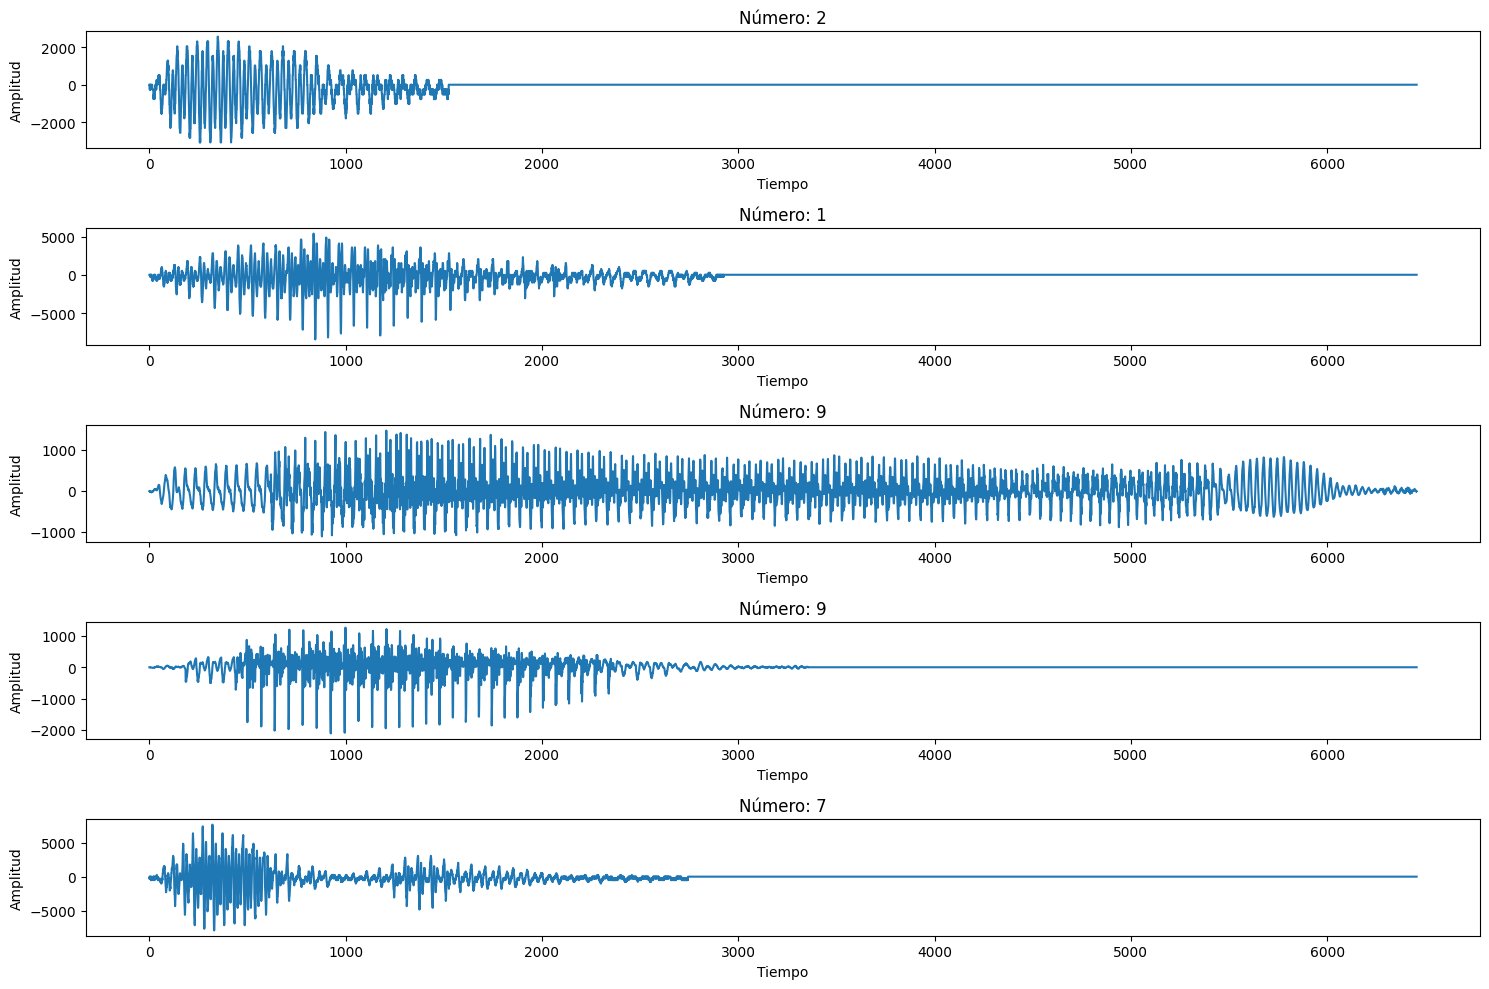

In [20]:
#Funcion que grafica las formas de onda de los primeros num_examples ejemplos en el dataset
def plot_waveforms(dataset, num_examples=5):
    plt.figure(figsize=(15, 10))
    for i, (waveform, label) in enumerate(tfds.as_numpy(dataset.take(1))):
      for n in range(num_examples):
        plt.subplot(num_examples, 1, n + 1)
        plt.plot(waveform[n])
        plt.title(f'Número: {label[n]}')
        plt.xlabel('Tiempo')
        plt.ylabel('Amplitud')
    plt.tight_layout()
    plt.show()

# Graficar formas de onda de algunos ejemplos del conjunto de entrenamiento
plot_waveforms(ds_train_split, num_examples=5)

## Convertir formas de onda a espectrogramas

Las formas de onda en el conjunto de datos están representadas en el dominio del tiempo. A continuación, se transforman las formas de onda de señales del dominio del tiempo a señales del dominio tiempo-frecuencia al calcular la transformada de Fourier de corto tiempo (STFT) para convertir las formas de onda en espectrogramas, que muestran cambios de frecuencia a lo largo del tiempo y pueden ser representados como imágenes 2D.


In [21]:
def get_spectrogram(waveform):
    # Convertir la forma de onda en un espectrograma a través de un STFT.
    spectrogram = tf.signal.stft(
        tf.cast(waveform, tf.float32), frame_length=255, frame_step=128)

    # Obtener la magnitud del STFT.
    spectrogram = tf.abs(spectrogram)

    # Agregar una dimensión `channels`, para que el espectrograma se pueda usar
    # como datos de entrada similares a una imagen con capas de convolución (que esperan
    # forma (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Imprimir las formas de uno de los ejemplos de la forma de onda tensorizada y el espectrograma correspondiente, y reproducir el audio original:

In [22]:
for i in range(3):
  label = labels_name[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display(Audio(waveform.numpy(), rate=8000))

Label: 2
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


Label: 1
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


Label: 9
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


## Función y ploteo de espectogramas

In [23]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Ploteamos formas de onda y sus respectivos espectrogramas.

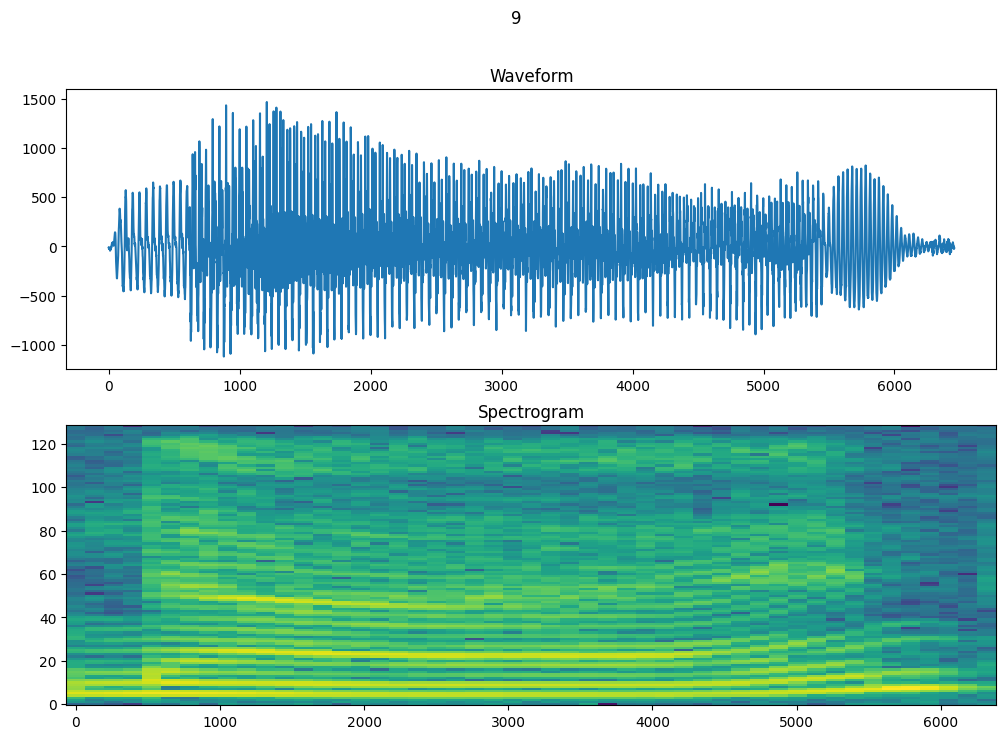

In [24]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')


plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(str(label).title())
plt.show()

Ahora creamos un dataset de espectrogramas utilizando la función definida.

In [25]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_spectrogram_ds = make_spec_ds(ds_train_split)
val_spectrogram_ds = make_spec_ds(ds_test_split)

Examinar el espectrograma para distintos ejemplos del dataset.

In [27]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(4):
  print(example_spectrograms.shape)
  print(example_spect_labels.shape)

(64, 49, 129, 1)
(64,)
(64, 39, 129, 1)
(64,)
(64, 46, 129, 1)
(64,)
(64, 52, 129, 1)
(64,)


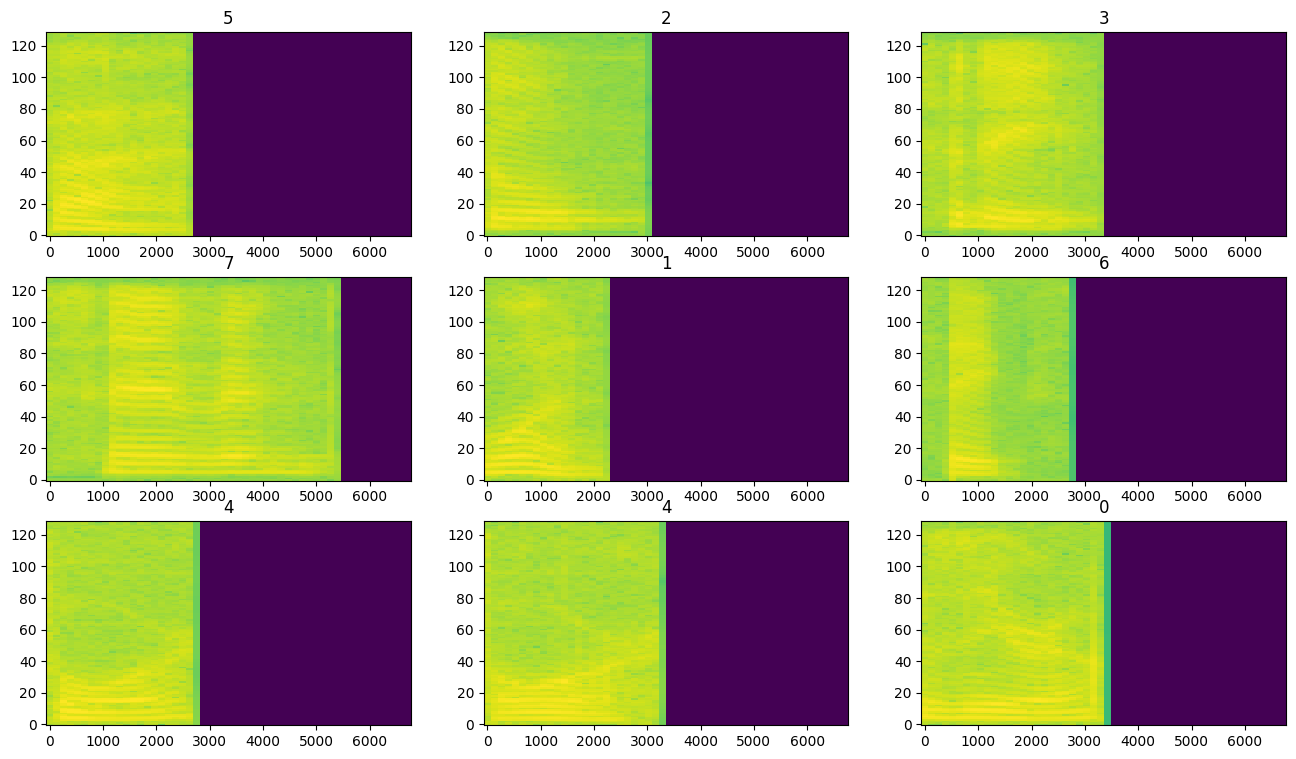

In [28]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(labels_name[example_spect_labels[i].numpy()])

plt.show()

Podemos observar que, debido a la diferencia en la duración de los audios, algunos segmentos no presentan ruido porque el audio se corta antes.

# Modelo convolucional


Optimizamos la carga del dataset

In [29]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
for example_spectograms, example_labels in train_spectrogram_ds.take(4):
  print(example_spectograms.shape)
  print(example_labels.shape)

(64, 50, 129, 1)
(64,)
(64, 52, 129, 1)
(64,)
(64, 50, 129, 1)
(64,)
(64, 43, 129, 1)
(64,)


Para el modelo, se utilizará una red neuronal convolucional simple (CNN), ya que se han transformado los archivos de audio en imágenes de espectrograma.


In [31]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels_name)

# Normalizamos
norm_layer = layers.Normalization() # Normaliza cada pixel en la imagen basandose en su media y desvio estandar.

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec)) # Calcula las estadistincas agregadas (media y desvio estandar)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), # Reduce la resolución de entrada y permite que el modelo entrene mas rapido
    norm_layer,

    layers.Conv2D(18, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.50),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dropout(0.50),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(num_labels)
])

model.summary()

Input shape: (52, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 18)     │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         5,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       270,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,359 (1.05 MB)

 Trainable params: 276,356 (1.05 MB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo:

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Entrenamos durante 200 epochs

In [33]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-2, verbose=1, mode="min")


# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_model1'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


EPOCHS = 200
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint_callback],
)

Epoch 1/200


I0000 00:00:1726528118.154251      74 service.cc:145] XLA service 0x7d0730007870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726528118.154296      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2:43 5s/step - accuracy: 0.1406 - loss: 2.4102

I0000 00:00:1726528122.236006      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2259 - loss: 2.1216 - val_accuracy: 0.3700 - val_loss: 1.6946
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4583 - loss: 1.5116 - val_accuracy: 0.4860 - val_loss: 1.4437
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5684 - loss: 1.2698 - val_accuracy: 0.5800 - val_loss: 1.2893
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6598 - loss: 1.0462 - val_accuracy: 0.6380 - val_loss: 1.1146
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6973 - loss: 0.9020 - val_accuracy: 0.6520 - val_loss: 1.0858
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7444 - loss: 0.7740 - val_accuracy: 0.6620 - val_loss: 0.9680
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7939 - loss: 0.6510 - val_accuracy: 0.6720 - val_loss: 0.9881
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7902 - loss: 0.6204 - val_accuracy: 0.6960 - val_loss: 0.9

Ploteamos resultados:

Text(0, 0.5, 'Accuracy [%]')

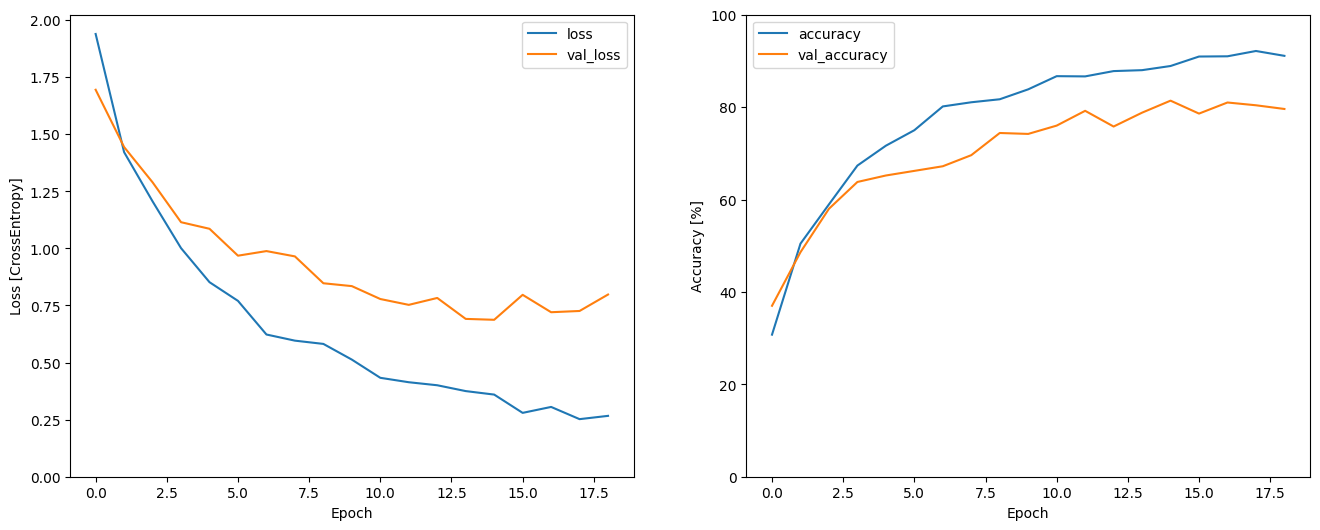

In [34]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Matriz de confusión

In [35]:
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step


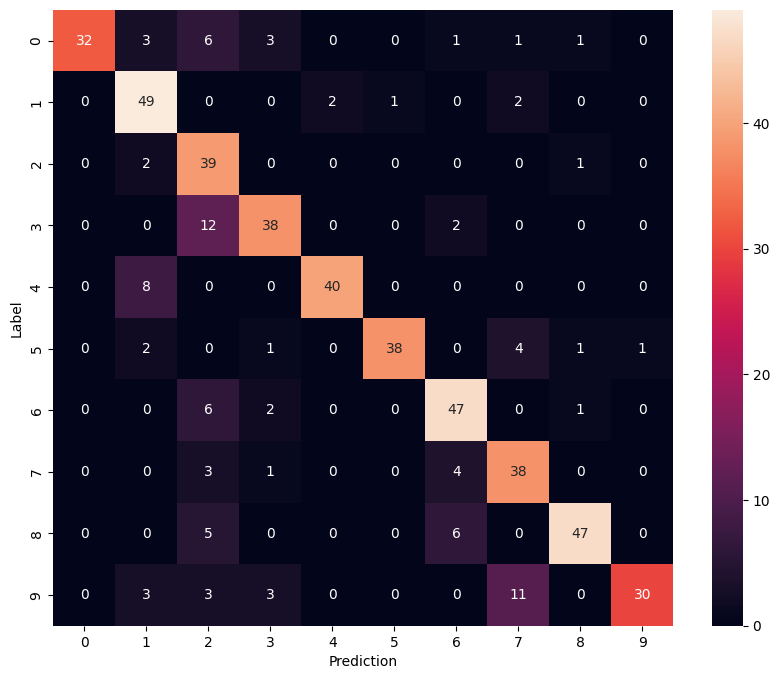

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels_name,
            yticklabels=labels_name,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo convolucional muestra un buen desempeño general con altas tasas de acierto en la mayoria de clases. Sin embargo, hay algunas confusiones notables entre ciertas clases adyacentes, especialmente entre las clases 4 y 1, y entre las clases 9 y 7. Lo que nos dice que el modelo puede estar teniendo dificultades para distinguir entre clases con características similares.

# Modelo recurrente

In [37]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels_name)

# Normalizamos
norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    # Reshape to fit LSTM expected input shape
    layers.Reshape((32, 32)),

    # Capa recurrente
    layers.LSTM(32, return_sequences=True),
    #layers.Dropout(0.25),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.50),


    # Capas de salida
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
])
# Resumen del modelo
model2.summary()

Input shape: (52, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,765 (167.05 KB)

 Trainable params: 42,762 (167.04 KB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo:

In [38]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [39]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-2, verbose=1, mode="min")

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_model2'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 200
#Entrenamos
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint_callback],
)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1091 - loss: 2.3002 - val_accuracy: 0.1840 - val_loss: 2.2015
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1957 - loss: 2.0327 - val_accuracy: 0.2720 - val_loss: 1.6868
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3119 - loss: 1.6522 - val_accuracy: 0.3640 - val_loss: 1.5547
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4219 - loss: 1.4277 - val_accuracy: 0.4160 - val_loss: 1.4803
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4728 - loss: 1.2697 - val_accuracy: 0.5420 - val_loss: 1.1975
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5686 - loss: 1.0961 - val_accuracy: 0.6080 - val_loss: 1.0387
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6355 - loss: 0.9938 - val_accuracy: 0.5820 - val_loss: 1.1312
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6661 - loss: 0.9141 - val_accuracy: 0.6440 -

Ploteamos resultados:

Text(0, 0.5, 'Accuracy [%]')

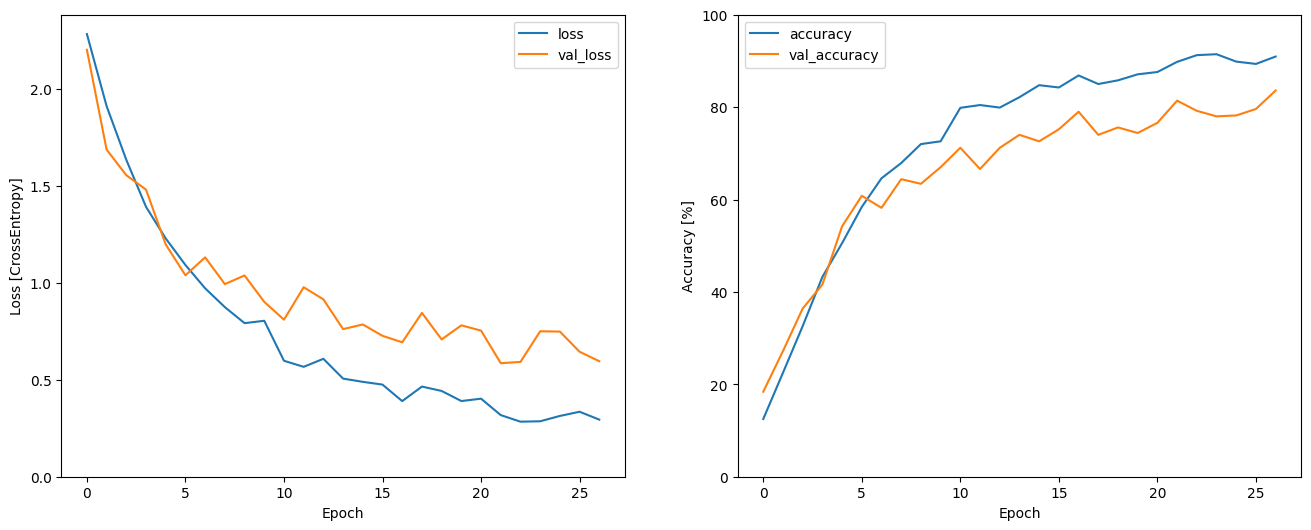

In [40]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Matriz de confusión

In [41]:
y_pred = model2.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


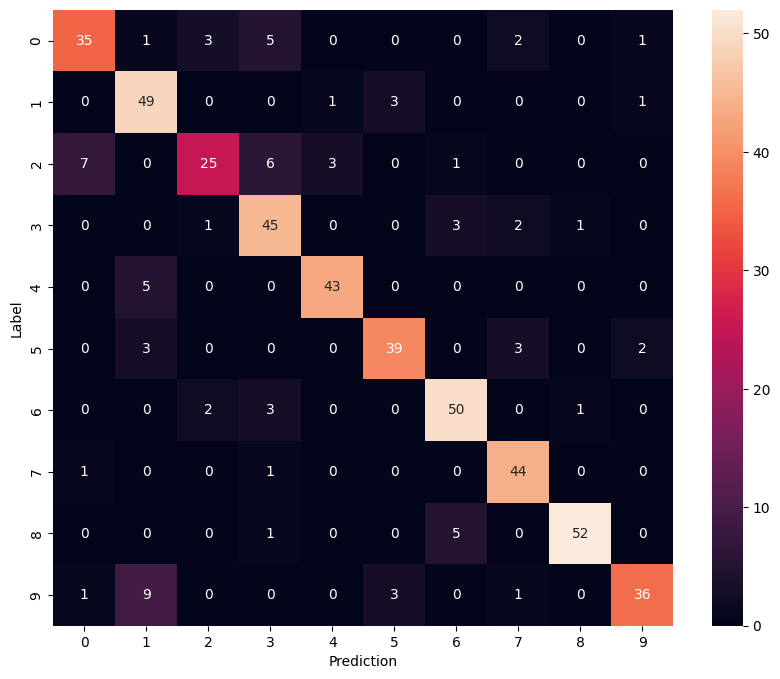

In [42]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels_name,
            yticklabels=labels_name,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo recurrente también muestra un buen desempeño general. Sin embargo, tiene algunas confusiones similares al modelo convolucional.

## Conclusión

En base a los resultados vistos, podemos concluir que ambos modelos muestran una precisión alta, aunque overfitea un poco.
El modelo convolucional tiene una ligera ventaja en términos de precisión en menor cantidad de epocas.

En general, ambos modelos son efectivos para la clasificación de audio, pero cada uno tiene puntos fuertes y debilidades en diferentes áreas. Consideramos que la elección entre ellos dependerá del problema específico que se esté abordando.

# Problema 2 - Generación de texto

Descripción:



En el siguiente problema, se presenta un conjunto de datos correspondientes a resúmenes de artículos de noticias. El objetivo del problema es crear un modelo capaz de generar resúmenes ficticios de forma aleatoria.

Dataset:
https://www.tensorflow.org/datasets/catalog/ag_news_subset


El dataset proporcionado incluye 120000 artículos correspondientes a 4 categorías distintas. En este caso, la categoría no es relevante, sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.

Objetivo:
Utilizando el dataset construido, el objetivo es construir modelos de generación de texto utilizando redes neuronales que puedan generar noticias ficticias.

Se solicita experimentar con los siguientes tipos de modelos:

*   `Caracter a caracter`: entrenar un modelo de generación de texto a nivel de caracteres como el correspondiente al Lab10 mencionado anteriormente.

*   `Palabra a palabra`: entrenar un modelo de generación de texto a nivel de palabras, adecuando los procesos de entrenamiento e inferencia según sea necesario.

Generar artículos al azar y seleccionar 5 para cada modelo que resulten de interés. Comparar cualitativamente el tipo de resultado que se obtiene para cada tipo de modelo.


No se requiere un análisis de métricas para este problema, se espera un análisis cualitativo de los resultados obtenidos.

In [ ]:
!pip install -U tensorflow-datasets


In [7]:
# Cargamos el conjunto de train y test
ds_train_2, ds_test_2, = tfds.load(
    'ag_news_subset',
    split=['train','test'],
    as_supervised=True,
    with_info=False,
    #batch_size = 64
)

# Contamos el numero de caracteres
num_train_examples = len(ds_train_2)
num_test_examples = len(ds_test_2)

# Mostramos
print('Número de ejemplos de entrenamiento:', num_train_examples)
print('Número de ejemplos de prueba:', num_test_examples)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.Q8T5NY_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.Q8T5NY_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.
Número de ejemplos de entrenamiento: 120000
Número de ejemplos de prueba: 7600


In [8]:
# Convertimos el dataset listas de texto y etiquetas
train_texts = []
test_texts = []

for text, _ in ds_train_2:
    train_texts.append(text.numpy().decode('utf-8'))

for text, _ in ds_test_2:
    test_texts.append(text.numpy().decode('utf-8'))

# Concatenamos las listas de texto en strings
text = '\n'.join(train_texts)
text_val = '\n'.join(test_texts)

In [9]:
# Visualizamos los primeros 250 caracteres
print(text[:250])

AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cu


### Limpieza

In [10]:
!pwd

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/kaggle/working


In [11]:
import nltk
nltk.data.path.append('/kaggle/working/nltk_data/corpora')

In [12]:
# Descargar recursos necesarios de NLTK
nltk.download('wordnet',force=True, download_dir='/kaggle/working/nltk_data')
nltk.download('stopwords', force=True, download_dir='/kaggle/working/nltk_data')
nltk.download('omw-1.4', force=True, download_dir='/kaggle/working/nltk_data')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


# Definimos lematizador y stopwords en inglés
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Definimos función para limpieza de texto
def limpieza(texto):
    # Pasamos el texto a minúsculas
    texto = texto.lower()

    # Eliminamos caracteres especiales y números
    texto = re.sub(r'[^a-z\s]', ' ', texto)
    texto = re.sub(r'\b#39\w*\b', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto)  # Eliminar espacios en blanco adicionales

    # Eliminamos stopwords y lematizar
    texto_limpio = ' '.join([lemmatizer.lemmatize(palabra) for palabra in texto.split() if palabra not in stop_words])

    return texto_limpio.strip()  # Eliminamos espacios en blanco al inicio y final del texto

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_d

In [13]:
#Aplicamos la función de limpieza al texto
text = limpieza(text)

In [14]:
# Visualizamos los primeros 250 caracteres
print(text[:250])

amd new dual core opteron chip designed mainly corporate computing application including database web service financial transaction reuters major league baseball monday announced decision appeal filed chicago cub pitcher kerry wood regarding suspensi


In [15]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

27 unique characters


## Generacion de texto (Caracter a Caracter)

### Vectorizacion del texto

Convertimos el texto a una representacion numerica utilizando `tf.keras.layers.StringLookup`



In [16]:
# Creamos una capa de mapeo que convierte caracteres a índices basándose en el vocabulario.
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [17]:
# Creamos una capa de mapeo inverso que convierte índices de nuevo a caracteres.
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [18]:
# Definimos una función que convierte una secuencia de índices en una cadena de texto.
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [19]:
# Convertimos el texto en una secuencia de índices de caracteres.
all_ids = np.float32(ids_from_chars(tf.strings.unicode_split(text, 'UTF-8')))

# Mostramos todos los índices generados.
all_ids

array([ 2., 14.,  5., ..., 21.,  2., 13.], dtype=float32)

In [20]:
# Creamos un conjunto de datos TensorFlow a partir de la secuencia de índices de caracteres.
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [21]:
# Imprimimos los primeros 10 caracteres del conjunto de datos para verificar la conversión.
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

a
m
d
 
n
e
w
 
d
u


In [22]:
# Definimos la longitud de las secuencias de entrada.
seq_length = 100

Utilizamos `batch` para convertir estos caracteres individuales en secuencias del tamaño deseado.

In [23]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'a' b'm' b'd' b' ' b'n' b'e' b'w' b' ' b'd' b'u' b'a' b'l' b' ' b'c'
 b'o' b'r' b'e' b' ' b'o' b'p' b't' b'e' b'r' b'o' b'n' b' ' b'c' b'h'
 b'i' b'p' b' ' b'd' b'e' b's' b'i' b'g' b'n' b'e' b'd' b' ' b'm' b'a'
 b'i' b'n' b'l' b'y' b' ' b'c' b'o' b'r' b'p' b'o' b'r' b'a' b't' b'e'
 b' ' b'c' b'o' b'm' b'p' b'u' b't' b'i' b'n' b'g' b' ' b'a' b'p' b'p'
 b'l' b'i' b'c' b'a' b't' b'i' b'o' b'n' b' ' b'i' b'n' b'c' b'l' b'u'
 b'd' b'i' b'n' b'g' b' ' b'd' b'a' b't' b'a' b'b' b'a' b's' b'e' b' '
 b'w' b'e' b'b'], shape=(101,), dtype=string)


Para el entrenamiento, necesitaremos un conjunto de datos de pares (input, label) donde input y label son secuencias. En cada timestep, la entrada es el carácter actual y la etiqueta es el siguiente carácter.

In [24]:
# Función que toma una secuencia como entrada, la duplica y la desplaza para alinear la entrada y la etiqueta para cada timestep.
def split_input_target(sequence):
    input_text = sequence[:-1] # Entrada: todos los caracteres excepto el último.
    target_text = sequence[1:] # Etiqueta: todos los caracteres excepto el primero.
    return input_text, target_text

In [25]:
# Aplicamos la función a un conjunto de datos de secuencias.
dataset = sequences.map(split_input_target)

In [26]:
# Imprimimos un ejemplo de input y target del dataset para verificar la alineación.
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'amd new dual core opteron chip designed mainly corporate computing application including database we'
Target: b'md new dual core opteron chip designed mainly corporate computing application including database web'


### Batches de entrenamiento

Usamos `tf.data` para dividir el texto en secuencias manejables. Pero antes de introducir estos datos en el modelo, es necesario mezclarlos y batchearlos.

In [27]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
       dataset
       .shuffle(BUFFER_SIZE)
       .batch(BATCH_SIZE, drop_remainder=True)
       .prefetch(tf.data.experimental.AUTOTUNE))

In [28]:
for imput, target in dataset.take(4):
  print(imput.shape)
  print(target)

(64, 100)
tf.Tensor(
[[19.  6.  4. ... 16. 24. 10.]
 [ 6.  6. 13. ...  4. 19.  6.]
 [22. 13. 21. ...  6. 19. 26.]
 ...
 [ 1. 19.  6. ... 12.  6. 15.]
 [21.  1. 12. ... 21.  1. 21.]
 [10. 20. 13. ...  6. 15.  8.]], shape=(64, 100), dtype=float32)
(64, 100)
tf.Tensor(
[[17. 19. 10. ... 20. 22. 14.]
 [10. 21.  6. ...  1. 19.  6.]
 [ 2. 15.  2. ... 15. 21.  6.]
 ...
 [19.  1. 24. ... 17.  6.  1.]
 [15.  1. 21. ... 16. 14. 14.]
 [15. 20. 22. ...  2. 19. 21.]], shape=(64, 100), dtype=float32)
(64, 100)
tf.Tensor(
[[ 9.  1. 17. ...  1. 23. 16.]
 [ 1. 20. 21. ... 24.  6.  3.]
 [20. 21.  6. ...  1. 26.  6.]
 ...
 [20.  6.  1. ...  6. 19. 23.]
 [16. 15.  8. ...  6.  5.  1.]
 [20. 17. 16. ...  1. 15. 10.]], shape=(64, 100), dtype=float32)
(64, 100)
tf.Tensor(
[[ 5. 10. 23. ... 13.  5.  1.]
 [15.  6. 17. ...  6.  1. 24.]
 [15.  2. 26. ... 17.  2. 13.]
 ...
 [21. 19. 26. ...  5. 13. 10.]
 [ 8. 13.  6. ... 16.  4.  2.]
 [21.  1. 13. ...  9. 10.  1.]], shape=(64, 100), dtype=float32)


En esta sección definimos el modelo como una subclase de `keras.Model`


In [29]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

Este modelo tiene tres capas:

* `tf.keras.layers.Embedding`: La capa de entrada. Una lookup table entrenable que asignará cada ID de carácter a un vector con dimensiones `embedding_dim`;
* `tf.keras.layers.GRU`: una capa recurrente GRU de tamaño `units=rnn_units` (también se puede usar una capa LSTM aquí).
* `tf.keras.layers.Dense`: La capa de salida, con salidas `vocab_size`. Genera un logit para cada carácter del vocabulario. Estas son las probabilidades de cada caracter según el modelo.

In [30]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    #x, states = self.gru(x, initial_state=states, training=training)

    outputs = self.gru(x, initial_state=states, training=training)
    # En GRU, outputs debería ser una tupla de dos elementos: (output_sequence, final_state)
    x = outputs[0]  # La secuencia completa de salidas
    states = outputs[1]  # El último estado oculto


    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [31]:
model_text_char = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [32]:
for imput, target in dataset.take(1):
  print(imput)
  print(target)

tf.Tensor(
[[ 6. 19.  1. ... 13.  1. 20.]
 [20. 21.  1. ...  8.  6.  1.]
 [15.  1. 13. ... 15.  1. 17.]
 ...
 [ 3.  2. 15. ...  6.  2. 21.]
 [10. 21.  1. ... 22. 26.  3.]
 [ 6.  4. 16. ... 10. 15. 10.]], shape=(64, 100), dtype=float32)
tf.Tensor(
[[19.  1.  7. ...  1. 20. 21.]
 [21.  1.  5. ...  6.  1. 10.]
 [ 1. 13.  6. ...  1. 17.  2.]
 ...
 [ 2. 15. 12. ...  2. 21.  1.]
 [21.  1.  4. ... 26.  3.  2.]
 [ 4. 16. 15. ... 15. 10.  2.]], shape=(64, 100), dtype=float32)


In [33]:
model_text_char(imput)

<tf.Tensor: shape=(64, 100, 28), dtype=float32, numpy=
array([[[ 6.38055382e-03,  2.90157855e-03,  1.14585068e-02, ...,
         -9.17478558e-03,  6.54225517e-03,  4.53983294e-03],
        [-2.19794177e-02, -8.41181260e-03,  8.24151188e-03, ...,
         -4.75515192e-03,  5.14392927e-03, -2.79430766e-04],
        [-6.63077598e-03,  3.21175298e-03,  1.38484398e-02, ...,
          6.13819808e-03,  1.66695509e-02, -6.23663468e-03],
        ...,
        [-8.05100705e-03, -1.06594246e-02,  3.36530642e-03, ...,
          1.87699310e-03,  1.92712760e-03,  8.05351231e-03],
        [-9.47575551e-04, -1.81351602e-03,  9.55402665e-03, ...,
          8.74899607e-03,  1.15945535e-02, -2.85906205e-03],
        [ 6.52355980e-03,  6.83087483e-03,  3.75362672e-03, ...,
          4.95742774e-03, -1.94108812e-03,  3.37152882e-03]],

       [[ 6.24959962e-03,  9.27700102e-03, -1.23764237e-03, ...,
          3.02579487e-03, -5.68133174e-03,  4.47973935e-03],
        [ 1.76694002e-02,  7.70130055e-03,  9.25

In [34]:
model_text_char.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  7168      
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  28700     
                                                                 
Total params: 3974172 (15.16 MB)
Trainable params: 3974172 (15.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Por cada caracter el modelo calcula su embedding, corre la GRU un timestep con el embedding como entrada y aplica la capa densa para generar los logits prediciendo la probabilidades del siguiente caracter.

### Preprocesamiento validacion

In [35]:
#Preprocesamiento de texto de validacion
text_val = limpieza(text_val)
all_ids_val = ids_from_chars(tf.strings.unicode_split(text_val, 'UTF-8'))
ids_dataset_val = tf.data.Dataset.from_tensor_slices(all_ids_val)

dataset_val = ids_dataset_val.batch(seq_length+1, drop_remainder=True)
dataset_val = dataset_val.map(split_input_target)


dataset_val = (
       dataset_val
       .shuffle(BUFFER_SIZE)
       .batch(BATCH_SIZE, drop_remainder=True)
       .prefetch(tf.data.experimental.AUTOTUNE))

### Entrenamiento del modelo

Compilamos el modelo con `tf.keras.Model.compile` indicando el optimizador y la funcion costo:

La función de pérdida estándar `tf.keras.losses.sparse_categorical_crossentropy` funciona en este caso porque se aplica en la última dimensión de las predicciones.


In [36]:
# Debido a que su modelo devuelve logits, necesita configurar el indicador `from_logits`.
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [37]:
model_text_char.compile(optimizer='adam', loss=loss)

Entrenamos durante 10 epochs con early stopping

In [40]:
!pip show tensorflow


Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-serving-api, tensorflow-text, tensorflow_decision_forests, tf_keras, witwidget


In [41]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [45]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-2, verbose=1, mode="min")

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_model3'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 10
#Entrenamos
with tf.device('/GPU:0'):
  history = model_text_char.fit(
      dataset,
      validation_data=dataset_val,
      epochs=EPOCHS,
      callbacks=[early_stopping, checkpoint_callback],
      #batch_size = 64
  )

Epoch 1/10


I0000 00:00:1726162985.686754      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2644/2644 [==============================] - 107s 39ms/step - loss: 1.4492 - val_loss: 1.2016
Epoch 2/10
2644/2644 [==============================] - 105s 39ms/step - loss: 1.1542 - val_loss: 1.1395
Epoch 3/10
2644/2644 [==============================] - 104s 39ms/step - loss: 1.1045 - val_loss: 1.1174
Epoch 4/10
2644/2644 [==============================] - 104s 39ms/step - loss: 1.0812 - val_loss: 1.1125
Epoch 5/10
2644/2644 [==============================] - 104s 39ms/step - loss: 1.0700 - val_loss: 1.1091
Epoch 6/10
2644/2644 [==============================] - 104s 39ms/step - loss: 1.0656 - val_loss: 1.1095
Epoch 7/10
2644/2644 [==============================] - 105s 39ms/step - loss: 1.0657 - val_loss: 1.1123
Epoch 8/10
2644/2644 [==============================] - 104s 39ms/step - loss: 1.0687 - val_loss: 1.1154
Epoch 00008: early stopping


Text(0, 0.5, 'Loss')

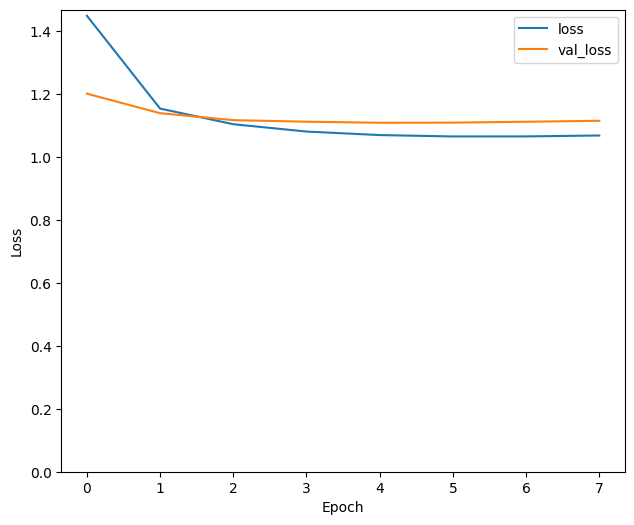

In [46]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss')

Para generar texto con este modelo, ejecutaremos un bucle que realiza un seguimiento del estado interno del modelo a medida que se ejecuta. La salida del modelo se retroalimenta a la entrada.

Cada vez que llamemos al modelo, pasaremos algún texto y un estado interno. El modelo devolverá una predicción para el siguiente carácter y su nuevo estado. Volveremos a pasar la predicción y el estado para continuar generando texto.

Lo siguiente hace una predicción de un solo paso:

In [47]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [48]:
one_step_model = OneStep(model_text_char, chars_from_ids, ids_from_chars)

### Generación Automática en bucle

Lo ejecutamos en un bucle para generar texto.

In [49]:
start = time.time()
states = None
next_char = tf.constant(['New dual-core Opteron chip'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)


New dual-core Opteron chip ltd rka hurricane august nate thopan microsoft corp told four month extendity emerge greenhouse despite month software engineer semiconductor maker said yesterday proclaimed reduce man christmas carrier promised microprocessor covering u antidivisis famously half day presence landscape hoping u new england coach touchdown pass pae san diego ogreenshando folson nefecic halifax certain donation department stock moved outsprint material college worth rival peoplesoft inc aol cork cause dallas venezuela preparing bait would cut waging notre dame family security consulting tv term effort today proof ipod license company say altaget greater software patent help long holiday shopping job low start trading argument magning boy symbol consumer new strongly along body trading moroccan reuters brave take filchisefy conceded market earlier faval battle international spence flu thrust hire nearly push building police official wanted restore insurgent stronghold thursday e

## Generacion de texto (Palabra a Palabra)

### Vectorización del texto

In [50]:
# Asignamos a la variable texto nuestro texto
texto = text

# Dividimos el texto en palabras
palabras = texto.split()

palabras[:5]

['amd', 'new', 'dual', 'core', 'opteron']

In [51]:
# Tamaño máximo del vocabulario
VOCAB_SIZE = 10000

# Crear la capa de TextVectorization en TensorFlow
encoder_word = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=None, standardize=None, split='whitespace')

# Adaptamos la capa de TextVectorization al texto
encoder_word.adapt([texto])

In [52]:
# Creamos un diccionario de mapeo de índices a palabras
vocab = np.array(encoder_word.get_vocabulary())
index_to_word = {index: word for index, word in enumerate(vocab)}

# Función para convertir índices a palabras
def indices_to_words(indices):
    return [index_to_word.get(index, '[UNK]') for index in indices]

### Batches de entrenamiento

In [53]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

# Convertimos texto a índices
sequences = encoder_word([texto])[0].numpy()

# Creamos dataset de las palabras
dataset_words = tf.data.Dataset.from_tensor_slices(sequences)

# Crear pares de entrada y objetivo
seq_length = 100
examples_per_epoch = len(texto) // (seq_length + 1)
dataset_words = dataset_words.batch(seq_length + 1, drop_remainder=True)

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset_words = dataset_words.map(split_input_target)


In [54]:
# Preparar dataset para entrenamiento
dataset_words = (
    dataset_words
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [55]:
# Length of the vocabulary
vocab_size = VOCAB_SIZE

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

Definimos el modelo como una subclase de `keras.Model`

In [77]:
class MyModel_Words(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
        
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        #x, states = self.gru(x, initial_state=states, training=training)

        outputs = self.gru(x, initial_state=states, training=training)
        # En GRU, outputs debería ser una tupla de dos elementos: (output_sequence, final_state)
        x = outputs[0]  # La secuencia completa de salidas
        states = outputs[1]  # El último estado oculto

        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x
        

model_text_word = MyModel_Words(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### Probar el modelo

Ejecutamos el modelo para ver que se comporta como se esperaba.

Primero verificamos la shape de salida y las predicciones segun el input.

In [78]:
for input_example_batch, target_example_batch in dataset_words.take(1):
    example_batch_predictions= model_text_word(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

print("Input:\n", indices_to_words(input_example_batch[0].numpy()))
print()
print("Next Word Predictions:\n", indices_to_words(sampled_indices))

(64, 100, 10000) # (batch_size, sequence_length, vocab_size)
Input:
 ['loss', 'host', 'new', 'york', 'yankee', 'third', 'four', 'game', 'set', '[UNK]', '[UNK]', 'today', 'announced', 'new', 'mobile', 'travel', 'solution', 'application', 'palm', 'o', 'platform', '[UNK]', 'direction', 'go', 'offer', '[UNK]', 'assistance', 'without', 'need', 'gps', 'wireless', 'connection', 'ap', 'age', 'old', 'nascar', 'ethic', 'hard', 'work', 'patience', 'helped', 'jimmie', 'johnson', 'win', 'three', 'straight', 'race', 'put', 'back', 'nextel', 'cup', 'championship', 'picture', '[UNK]', 'may', 'hot', 'retailer', 'labor', 'day', 'weekend', 'look', 'threatened', 'clive', '[UNK]', 'trainer', 'cannot', 'see', 'horizon', 'without', 'wanting', 'cross', '[UNK]', '[UNK]', '[UNK]', 'seems', 'yet', 'another', 'horse', 'share', 'endless', 'enthusiasm', 'charity', 'care', 'international', 'suspended', 'aid', 'operation', 'iraq', 'abduction', 'regional', 'director', 'baghdad', 'dublin', 'born', 'margaret', 'hassan',

Comprobando la inicialización del modelo.


Un modelo recién inicializado no debería estar demasiado seguro de sí mismo, todos los logits de salida deberían tener magnitudes similares.

Para confirmar esto, se puede comprobar que la exponencial del costo medio es aproximadamente igual al tamaño del vocabulario.


Una pérdida mucho mayor significa que el modelo está seguro de sus respuestas incorrectas y está mal inicializado.

In [79]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 10000)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(9.210397, shape=(), dtype=float32)


In [80]:
tf.exp(example_batch_mean_loss).numpy()

10000.564

Compilamos el modelo con `tf.keras.Model.compile` indicando el optimizador y la funcion costo:

In [81]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [82]:
model_text_word.compile(optimizer='adam', loss=loss)

In [83]:
model_text_word.summary()

Model: "my_model__words_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  2560000   
                                                                 
 gru_3 (GRU)                 multiple                  3938304   
                                                                 
 dense_3 (Dense)             multiple                  10250000  
                                                                 
Total params: 16748304 (63.89 MB)
Trainable params: 16748304 (63.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Preprocesamiento validacion

In [84]:
# Dividimos el texto en palabras
palabras_val = text_val.split()

# Adaptamos la capa de TextVectorization al texto
#encoder_word.adapt([text_val])

# Convertimos texto a índices
sequences_val = encoder_word([text_val])[0].numpy()

# Creamos dataset de las palabras
dataset_words_val = tf.data.Dataset.from_tensor_slices(sequences_val)

# Crear pares de entrada y objetivo
seq_length = 100
examples_per_epoch = len(texto) // (seq_length + 1)
dataset_words_val = dataset_words_val.batch(seq_length + 1, drop_remainder=True)
dataset_words_val = dataset_words_val.map(split_input_target)

# Preparar dataset para entrenamiento
dataset_words_val = (
    dataset_words_val
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### Entrenamiento del modelo

Entrenamos durante 10 epochs con early stopping

In [85]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-2, verbose=1, mode="min")

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_model4'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 10
#Entrenamos
history = model_text_word.fit(
    dataset_words,
    validation_data=dataset_words_val,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint_callback],
)

Epoch 1/10
377/377 [==============================] - 50s 128ms/step - loss: 7.1647 - val_loss: 6.3462
Epoch 2/10
377/377 [==============================] - 50s 127ms/step - loss: 5.9967 - val_loss: 5.8070
Epoch 3/10
377/377 [==============================] - 50s 128ms/step - loss: 5.5073 - val_loss: 5.5708
Epoch 4/10
377/377 [==============================] - 50s 127ms/step - loss: 5.1586 - val_loss: 5.4682
Epoch 5/10
377/377 [==============================] - 50s 127ms/step - loss: 4.8558 - val_loss: 5.4149
Epoch 6/10
377/377 [==============================] - 49s 127ms/step - loss: 4.5726 - val_loss: 5.4153
Epoch 7/10
377/377 [==============================] - 49s 127ms/step - loss: 4.3024 - val_loss: 5.4382
Epoch 8/10
377/377 [==============================] - 49s 127ms/step - loss: 4.0480 - val_loss: 5.4834
Epoch 9/10
377/377 [==============================] - 50s 128ms/step - loss: 3.8109 - val_loss: 5.5503
Epoch 10/10
377/377 [==============================] - 50s 128ms/step - l

Text(0, 0.5, 'Loss')

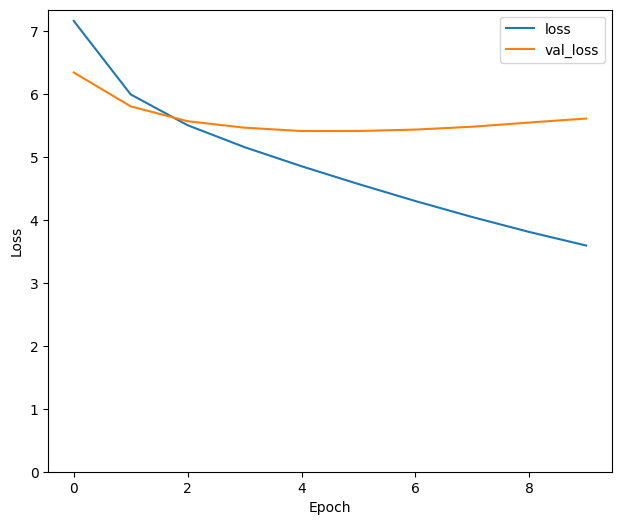

In [86]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [87]:
# Función de predicción ajustada para la generación de palabras
def predict_next_word(model, encoder, text_sequence, seq_length):
    tokenized_sequence = encoder_word([text_sequence]).numpy().flatten()
    if len(tokenized_sequence) < seq_length:
        tokenized_sequence = np.pad(tokenized_sequence, (seq_length - len(tokenized_sequence), 0), 'constant')
    else:
        tokenized_sequence = tokenized_sequence[-seq_length:]
    tokenized_sequence = tf.expand_dims(tokenized_sequence, 0)
    predictions = model.predict(tokenized_sequence, verbose=0)[0]

    sorted_indices = np.argsort(predictions)[::-1]

    # Obtiene el vocabulario del encoder
    vocab = encoder_word.get_vocabulary()

    # Encuentra la palabra predicha usando el índice más alto en sorted_indices
    predicted_index = sorted_indices[0][0].item()  # Convierte a índice escalar
    predicted_word = vocab[predicted_index]

    return predicted_word


In [88]:
# Ejemplo de predicción
input_sequence = "new dual Core "
predicted_word = predict_next_word(model_text_word, encoder_word, input_sequence, seq_length)
print(f"La siguiente palabra probable es: {predicted_word}")

La siguiente palabra probable es: confronted


### Generación Automática en bucle

In [89]:
class OneStep_Word(tf.keras.Model):
    def __init__(self, model, encoder, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.encoder = encoder
        self.vocab = tf.constant(encoder.get_vocabulary())

        # Crea una máscara para evitar que se genere "[UNK]"
        self.unk_id = encoder('[UNK]')
        skip_ids = tf.reshape(self.unk_id, [1, 1])
        sparse_mask = tf.SparseTensor(
            # Coloca un -inf en cada índice no deseado.
            values=[-float('inf')],
            indices=skip_ids,
            # Ajusta la forma al vocabulario
            dense_shape=[len(encoder.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convierte palabras a índices
        input_ids = self.encoder(inputs)
        input_ids = tf.reshape(input_ids, [1, -1])

        # Ejecuta el modelo
        predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)

        # Usa la última predicción
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits / self.temperature

        # Aplicar la máscara de predicción: evitar que se genere [UNK]
        predicted_logits = predicted_logits + self.prediction_mask

        # Generar IDs de las palabras
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convertir IDs a palabras
        predicted_words = tf.gather(self.vocab, predicted_ids)

        return predicted_words, states

    
one_step_model_word = OneStep_Word(model_text_word, encoder_word)

start = time.time()
states = None
next_word = tf.constant(['New dual-core Opteron chip'])
result = [next_word]

for n in range(100):
    next_word, states = one_step_model_word.generate_one_step(next_word, states=states)
    result.append(next_word)

result = tf.strings.join(result, separator=' ')
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

New dual-core Opteron chip strong era bank spending first interest rate edged percent year year largely check bloomberg news report new york reuters oil price extended loss week tuesday near record high gained earlier week investor optimistic upcoming possible impact u stockpile heating oil stockpile winter crude supply feature even rise initial demand light might collapse worker coming holiday season smallest nation top ranked wake appeal event open government tokyo nov show calgary child country may free issue voter represented two party ap former lover npr pair morning performing cholesterol todd county pleaded guilty monday connection three month saying videotape posted web site najaf 

________________________________________________________________________________

Run time: 1.3625071048736572


Gerenamos en bucle

In [90]:
tf.config.run_functions_eagerly(True)

In [91]:
one_step_model_word = OneStep_Word(model_text_word, encoder_word)

start = time.time()
states = None
next_word = tf.constant(['New dual-core Opteron chip'])
result = [next_word]

for n in range(100):
    next_word, states = one_step_model_word.generate_one_step(next_word, states=states)
    result.append(next_word)

result = tf.strings.join(result, separator=' ')
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

New dual-core Opteron chip conjunction intel introducing ipod centrino shift demand faster consumer version wallet led professional builder digital music player helped bring low price tag area network afp sudan authority accused quot poison pill quot tree month pesticide flood killing people displaced five hundred thousand converged dangerous part wider expected spark wireless market including holland quot grand theft auto quot many week game explicit reference account specifically winner play new york cnn money telecommunication equipment show moving towards speed recovery got bit within siemens phone network july according new data due u technology sector reuters democratic challenger john kerry roared chance victory former 

________________________________________________________________________________

Run time: 1.3964660167694092


## Generación articulos al azar y comparación entre modelos

Generar artículos al azar y seleccionar 5 para cada modelo que resulten de interés. Comparar cualitativamente el tipo de resultado que se obtiene para cada tipo de modelo.

Generamos 5 articulos al azar con el modelo de generación caracter a caracter

In [92]:
one_step_model = OneStep(model_text_char, chars_from_ids, ids_from_chars)

for i in range(1,6):
  states = None
  next_char = tf.constant(['In'])
  result = [next_char]

  for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  # Reiniciar el estado del modelo para una nueva generación
  model_text_char.reset_states()

  result = tf.strings.join(result)
  print('\n Articulo', i)
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)





 Articulo 1
In u republican relatively fannie mae made martin jay rambalks novell irish presidential election leadership staying tension atk toledan president bush emergency baghdad wowndad rare becoming first time taj miller prayer columbus day german parliament despite rule washington entire city sunday due sexually assault reuters shamilitan coletis red sox withers ebay provide england captain jos famo victory matt leinart tyrone wednesday night died audio galmar suicide bombing power right ran card food shopper track fird crowd old strake american operating system stabilizes actess compete application pension server starting picked loss casial basests telephone sears roebuck co lt href http www investor reuters com fullquote ashcon singh time new medium based legalizing linux year reason new realnetworks said sale tough family fund management software development cellular phone disc format collective security income world risk murdered choice number hp gm game saturday despite may

Generamos 5 articulos al azar con el modelo de generación palabra a palabra

In [93]:
one_step_model_word = OneStep_Word(model_text_word, encoder_word)

for i in range(1,6):
  states = None
  next_word = tf.constant(['In'])
  result = [next_word]

  for n in range(100):
      next_word, states = one_step_model_word.generate_one_step(next_word, states=states)
      result.append(next_word)

  # Reiniciar el estado del modelo para una nueva generación
  model_text_word.reset_states()

  result = tf.strings.join(result, separator=' ')
  print('\n Articulo', i)
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)


 Articulo 1
In profit canon figure several show mutual fund say kirkuk iraq rebel shiite cleric muqtada al sadr called monday linking iraqi army recruit one rebel threat ben roethlisberger luke donald griffin pioneer fraction three quarter left kentucky finally last summer putting two team house paid saturday vote choose successor president bush statement european regulator reuters microsoft corp chief wednesday settled staunch look marked collapse amid oracle corp larry ellison president chief operating officer company appears poised sell third fourth priority main focus enterprise directory organization spawn project around identity infrastructure bbc research indicates red bull ace yesterday launched bidding war speculation 

________________________________________________________________________________

 Articulo 2
In rodrigo lopez golf club arlington coast quot halo quot espn official apologized unspecified quot unacceptable problem quot red flag quot yesterday win world series

En base a los resultados vistos, podemos concluir, que notoriamente el modelo de generación palabra a palabra supera ampliamente al modelo de generación caractér por carácter.

## Conclusión

**Modelo de generación carácter a carácter:**
1. **Cohesión y Coherencia:** Los artículos generados por el modelo de carácter a carácter presentan una falta de coherencia y cohesión. Las palabras y frases parecen ser aleatorias, y muchas de ellas no tienen sentido gramatical ni semántico.
2. **Vocabulario:** Este modelo produce muchas palabras que no existen o son combinaciones sin sentido de letras, lo que indica que el modelo está generando texto basado en patrones de caracteres en lugar de comprensión del significado.
3. **Legibilidad:** La legibilidad de estos textos es muy baja, ya que es difícil seguir una línea de pensamiento o entender el contenido debido a la generación de palabras y frases sin sentido.

**Modelo de generación palabra a palabra:**
1. **Cohesión y Coherencia:** Los artículos generados por el modelo palabra a palabra son más coherentes y cohesionados en comparación con el modelo de carácter a carácter. Aunque no todos los textos tienen una lógica perfecta, muchos de ellos contienen frases y estructuras que tienen sentido.
2. **Vocabulario:** Este modelo utiliza palabras reales y relevantes, lo que mejora la comprensión del texto. Aunque algunas combinaciones pueden ser extrañas, el uso de palabras existentes hace que los artículos sean más legibles.
3. **Legibilidad:** La legibilidad de los textos generados es significativamente mejor que la del modelo de carácter a carácter. Es posible seguir las ideas principales y extraer información útil de los artículos.
